In [ ]:
using ModelingToolkit, MethodOfLines, DifferentialEquations, DomainSets

# Define the desiccant wheel model PDESystem

# One-dimensional honeycombed desiccant wheel (air: 1-dimensional, desiccant: 0-dimensional)

### 0. Independent and state Variables ###
@parameters t z                                    # Independent variables: Time and spatial variables  
@variables ωa(..) Ta(..) ωd(..) Td(..) W(..)    # State variables      # W: moisture content of the desiccant material (kg/kg) 
Dt = Differential(t)
Dz = Differential(z)
@variables Da(..) Ky(..) φw(..) Pws(..) Qst(..)

# @parameters h_const, ρa, A, P, Cpa, Cpv, Cpd, Cpl, Cpm, hv, fd, fm, Patm, p, p0, T0, u, Sh_const    # Dependent variables

λ = 0.0321           # λ in Zhang; Thermal conductivity of dry air (W/(m·K))
Nu = 2.45
a = 0.0015            # Half duct height (m)
b = 0.0015            # Half duct width (m)
r0 = 0.2              # Radius of desiccant wheel (m)
A = 2 * a * b         # Cross-sectional area (m^2)
P = 2b + 2 * sqrt(b^2 + (a * π)^2) * (3 + (2b / (a * π))^2) / (4 + (2b / (a * π))^2)  # Perimeter (m)
h_const = (Nu * ka * P) / (4 * A)  # heat transfer coefficient

h_const = h_const                 # Calculated heat transfer coefficient
Sh_const = 2.45                   # Sherwood number as constant
u = 3.0                          # Air velocity on both the process and regeneration side (m/s)
ρa = 1.2                          # Air density (kg/m3)
A = A                        # Cross-sectional area
P = P                      # Perimeter
Cpa = 1009                        # Specific heat of dry air (J/(kg·K))
Cpv = 2028                        # Specific heat of water vapor (J/(kg·K))
Cpd = 921                         # Specific heat of desiccant (J/(kg·K))
Cpl = 4179                       # Specific heat of liquid water (J/(kg·K))
Cpm = 900                         # Specific heat of matrix materials (J/(kg·K))
hv = 2358.0e3                     # Evaporation latent heat of water (J/(kg))
fd = 0.005                        # Specific desiccant mass (kg/m)
fm = 0.003                       # Specific matrix mass (kg/m)
Patm = 1.013e5                    # Atmospheric pressure (Pa)
p = 1.013e5                       # Air pressure (Pa)
p0 = 0.98e5                       # Reference pressure (Pa)
T0 = 256.0

α = Nu * λ * P / (4 * A)

### 1. Governing Equations ###

# Eq 1: Moisture conservation in air
# moist_cons_air = Dt(ωa(t,z)) + u * Dz(ωa(t,z)) ~ (Ky(t,z) * P / (ρa * A)) * (ωd(t,z) - ωa(t,z))
moist_cons_air = Dt(ωa(t,z)) + u * Dz(ωa(t,z)) + fd / (2 * A * ρa) * Dt(W(t,z)) ~ 0


# Eq 2: Energy conservation in air
# energy_cons_air = Dt(Ta(t,z)) + u * Dz(Ta(t,z)) ~ (h_const * P / (ρa * A * (Cpa + ωa(t,z) * Cpv))) * (Td(t,z) - Ta(t,z)) + (Ky(t,z) * Cpv * P / (ρa * A * (Cpa + ωa(t,z) * Cpv))) * (ωd(t,z) - ωa(t,z)) * (Ta(t,z) - Td(t,z))
energy_cons_air = Dt(Ta(t,z)) + u * Dz(Ta(t,z)) + (fd * (Cpd + Cpl * W(t,z)) + fm * Cpm) / (2 * A * ρa * (Cpa + Cpv * ωa(t,z))) * Dt(Td(t,z)) ~ (Ky(t,z) * P * Qst(t,z)) /(A * ρa * (Cpa + Cpv * ωa(t,z))) * (ωa(t,z) - ωd(t,z))

# Eq 3: Moisture conservation in desiccant     # ∂W/∂t
# moist_cons_des = Dt(W(t,z)) ~ (2 * Ky(t,z) * P / fd) * (ωa(t,z) - ωd(t,z))
moist_cons_des = Dt(W(t,z)) + (2 * Ky(t,z) * P / fd) * (ωd(t,z) - ωa(t,z)) ~ 0

# Eq 4: Energy conservation in desiccant
#=
energy_cons_des = Dt(Td(t,z)) ~ (2 * h_const * P / (fd * (Cpd + W(t,z) * Cpl) + fm * Cpm)) * (Ta(t,z) - Td(t,z)) +
                              (2 * Ky(t,z) * P * Qst(t,z) / (fd * (Cpd + W(t,z) * Cpl) + fm * Cpm)) * (ωa(t,z) - ωd(t,z)) +
                              (2 * Ky(t,z) * P * Cpv / (fd * (Cpd + W(t,z) * Cpl) + fm * Cpm)) * (ωa(t,z) - ωd(t,z)) * (Ta(t,z) - Td(t,z))
=#
energy_cons_des = Dt(Td(t,z)) + (2 * α * P) /(fd * (Cpd + Cpl * W(t,z)) + fm * Cpm) * (Td(t,z) - Ta(t,z)) + (2 * Ky(t,z) * P * Qst(t,z)) /(fd * (Cpd + Cpl * W(t,z)) + fm * Cpm) * (ωd(t,z) - ωa(t,z)) + (2 * Ky(t,z) * P * Cpv) /(fd * (Cpd + Cpl * W(t,z)) + fm * Cpm) * (ωd(t,z) - ωa(t,z)) * (Td(t,z) - Ta(t,z))

### 2. Auxiliary Equations ###

# Define Da as a function of Ta, Ky as a function of Da
# @variables Da(t, z) Ky(t, z) 
Da_eq = Da(t,z) ~ 2.302e-5 * p0 / p * (Ta(t,z) / T0)^1.81   # Mass diffusion coefficient (m2 s-1)
Ky_eq = Ky(t,z) ~ ρa * Sh_const * Da(t,z) * P / (4 * A)

# The equilibrium relative humidity on the surface of RD silica gel
φw_W_eq = φw(t,z) ~ 0.0078 - 0.0579 * W(t,z) - 24.1655 * W(t,z)^2 - 124.478 * W(t,z)^3 + 204.226 * W(t,z)^4

# ωd: Humidity ratio of air in equilibrium with the desiccant (kg kg-1)
Pws_Td_eq = Pws(t,z) ~ exp(23.1964 - 3816.44 / max(Td(t,z) - 46.13, 1e-3))
wd_φw_eq = ωd(t,z) ~ 0.622 * φw(t,z) / (Patm / Pws(t,z) - φw(t,z))

# Qst: heat of adsorption [J/kg H2O]
Qst_eq = Qst(t,z) ~ hv * (1.0 + 0.2843 * exp(-10.28 * W(t,z)))


### 3. Construct the PDESystem without parameters, initial, or boundary conditions ###

# Collect all equations
eqs = [moist_cons_air, energy_cons_air, moist_cons_des, energy_cons_des, wd_φw_eq, Pws_Td_eq, φw_W_eq, Da_eq, Ky_eq, Qst_eq]


# domain
L = 0.2             # Thickness of desiccant wheel (m)
timestep = 200.0
domains = [t ∈ IntervalDomain(0.0, timestep),
           z ∈ IntervalDomain(0.0, L)]


# Initial and boundary conditions 
## 先假设就是process
bcs = [ωa(t,0) ~ 19.25 / 1000,              # bc: fixed inlet humidity ratio
       Ta(t,0) ~ 273.15 + 34.3,             # bc: fixed inlet air temperature

       #=
       Dz(Ta(t,0)) ~ 0.0,         
       Dz(Ta(t,L)) ~ 0.0,
       Dz(ωa(t,0)) ~ 0.0,          
       Dz(ωa(t,L)) ~ 0.0, 
       Dz(Td(t,0)) ~ 0.0,
       Dz(Td(t,L)) ~ 0.0,
       Dz(ωd(t,0)) ~ 0.0,
       Dz(ωd(t,L)) ~ 0.0,
       Dz(W(t,0)) ~ 0.0,
       Dz(W(t,L)) ~ 0.0,
       =#

       ωa(0,z) ~ 0.02,            
       Ta(0,z) ~ 273.15 + 34.3,   

       W(0,z) ~ 0.015,                   
       ωd(0,z) ~ 0.01e-3,                 
       Td(0,z) ~ 273.15 + 10,        
]


vars = [ωa(t,z), Ta(t,z), W(t,z), Td(t,z), ωd(t,z), φw(t,z), Pws(t,z), Da(t,z), Ky(t,z), Qst(t,z)]




# Define the PDE system with only equations, time, and spatial variables
@named DW_model_pdesys = PDESystem(eqs, bcs, domains, [t,z], vars) # parameters

dz = L/10
discretization = MOLFiniteDifference([z=>dz], t, approx_order=2)


odeprob = discretize(DW_model_pdesys, discretization)


sol = solve(odeprob, Rodas5(); reltol=1e-6, abstol=1e-8, maxiters=10000)

#=
prob = discretize(DW_model_pdesys, discretization)
sys = structural_simplify(DW_model_pdesys)

sol = solve(simplified_prob, Rodas5())  # ; reltol=1e-6, abstol=1e-8, maxiters=10000
=#

sol[Ta(t,z)] .-273.15
sol[ωa(t,z)] .*1000
sol[Td(t,z)] .-273.15
sol[ωd(t,z)] .*1000
sol[W(t,z)]

sol[φw(t,z)]
sol[Pws(t,z)]
sol[Da(t,z)]
sol[Ky(t,z)]
sol[Qst(t,z)]


num_z_points = size(sol[ωa(t, z)], 2)



LoadError: MethodError: no method matching /(::Symbolics.CallWithMetadata{SymbolicUtils.FnType{Tuple, Real}, Base.ImmutableDict{DataType, Any}}, ::Float64)

[0mClosest candidates are:
[0m  /([91m::MutableArithmetics.Zero[39m, ::Any)
[0m[90m   @[39m [35mMutableArithmetics[39m [90mC:\Users\rzhsong\.julia\packages\MutableArithmetics\OfRUD\src\[39m[90m[4mrewrite.jl:74[24m[39m
[0m  /(::Any, [91m::ChainRulesCore.NotImplemented[39m)
[0m[90m   @[39m [36mChainRulesCore[39m [90mC:\Users\rzhsong\.julia\packages\ChainRulesCore\I1EbV\src\tangent_types\[39m[90m[4mnotimplemented.jl:43[24m[39m
[0m  /([91m::ChainRulesCore.NotImplemented[39m, ::Any)
[0m[90m   @[39m [36mChainRulesCore[39m [90mC:\Users\rzhsong\.julia\packages\ChainRulesCore\I1EbV\src\tangent_types\[39m[90m[4mnotimplemented.jl:42[24m[39m
[0m  ...


In [1]:
using ModelingToolkit, MethodOfLines, DifferentialEquations, DomainSets

# Define the desiccant wheel model PDESystem

# One-dimensional honeycombed desiccant wheel (air: 1-dimensional, desiccant: 0-dimensional)

### 0. Independent and state Variables ###
@parameters t z                                    # Independent variables: Time and spatial variables  
@variables ωa(..) Ta(..) ωd(..) Td(..) W(..)    # State variables      # W: moisture content of the desiccant material (kg/kg) 
Dt = Differential(t)
Dz = Differential(z)
@variables Da(..) Ky(..) φw(..) Pws(..) Qst(..)

# @parameters h_const, ρa, A, P, Cpa, Cpv, Cpd, Cpl, Cpm, hv, fd, fm, Patm, p, p0, T0, u, Sh_const    # Dependent variables

ka = 0.0321           # λ in Zhang; Thermal conductivity of dry air (W/(m·K))
Nu = 2.45
a = 0.0015            # Half duct height (m)
b = 0.0015            # Half duct width (m)
r0 = 0.2              # Radius of desiccant wheel (m)
A = 2 * a * b         # Cross-sectional area (m^2)
P = 2b + 2 * sqrt(b^2 + (a * π)^2) * (3 + (2b / (a * π))^2) / (4 + (2b / (a * π))^2)  # Perimeter (m)
h_const = (Nu * ka * P) / (4 * A)  # heat transfer coefficient

h_const = h_const                 # Calculated heat transfer coefficient
Sh_const = 2.45                   # Sherwood number as constant
u = 3.0                          # Air velocity on both the process and regeneration side (m/s)
ρa = 1.2                          # Air density (kg/m3)
A = A                        # Cross-sectional area
P = P                      # Perimeter
Cpa = 1009                        # Specific heat of dry air (J/(kg·K))
Cpv = 2028                        # Specific heat of water vapor (J/(kg·K))
Cpd = 921                         # Specific heat of desiccant (J/(kg·K))
Cpl = 4179                       # Specific heat of liquid water (J/(kg·K))
Cpm = 900                         # Specific heat of matrix materials (J/(kg·K))
hv = 2358.0e3                     # Evaporation latent heat of water (J/(kg))
fd = 0.005                        # Specific desiccant mass (kg/m)
fm = 0.003                       # Specific matrix mass (kg/m)
Patm = 1.013e5                    # Atmospheric pressure (Pa)
p = 1.013e5                       # Air pressure (Pa)
p0 = 0.98e5                       # Reference pressure (Pa)
T0 = 256.0


### 1. Governing Equations ###

# Eq 1: Moisture conservation in air
moist_cons_air = Dt(ωa(t,z)) + u * Dz(ωa(t,z)) ~ (Ky(t,z) * P / (ρa * A)) * (ωd(t,z) - ωa(t,z))


# Eq 2: Energy conservation in air
energy_cons_air = Dt(Ta(t,z)) + u * Dz(Ta(t,z)) ~ (h_const * P / (ρa * A * (Cpa + ωa(t,z) * Cpv))) * (Td(t,z) - Ta(t,z)) + 
                                                  (Ky(t,z) * Cpv * P / (ρa * A * (Cpa + ωa(t,z) * Cpv))) * (ωd(t,z) - ωa(t,z)) * (Ta(t,z) - Td(t,z))

# Eq 3: Moisture conservation in desiccant     # ∂W/∂t
moist_cons_des = Dt(W(t,z)) ~ (2 * Ky(t,z) * P / fd) * (ωa(t,z) - ωd(t,z))

# Eq 4: Energy conservation in desiccant
energy_cons_des = Dt(Td(t,z)) ~ (2 * h_const * P / (fd * (Cpd + W(t,z) * Cpl) + fm * Cpm)) * (Ta(t,z) - Td(t,z)) +
                              (2 * Ky(t,z) * P * Qst(t,z) / (fd * (Cpd + W(t,z) * Cpl) + fm * Cpm)) * (ωa(t,z) - ωd(t,z)) +
                              (2 * Ky(t,z) * P * Cpv / (fd * (Cpd + W(t,z) * Cpl) + fm * Cpm)) * (ωa(t,z) - ωd(t,z)) * (Ta(t,z) - Td(t,z))


### 2. Auxiliary Equations ###

# Define Da as a function of Ta, Ky as a function of Da
# @variables Da(t, z) Ky(t, z) 
Da_eq = Da(t,z) ~ 2.302e-5 * p0 / p * (Ta(t,z) / T0)^1.81   # Mass diffusion coefficient (m2 s-1)
Ky_eq = Ky(t,z) ~ ρa * Sh_const * Da(t,z) * P / (4 * A)

# The equilibrium relative humidity on the surface of RD silica gel
φw_W_eq = φw(t,z) ~ 0.0078 - 0.0579 * W(t,z) - 24.1655 * W(t,z)^2 - 124.478 * W(t,z)^3 + 204.226 * W(t,z)^4

# ωd: Humidity ratio of air in equilibrium with the desiccant (kg kg-1)
Pws_Td_eq = Pws(t,z) ~ exp(23.1964 - 3816.44 / (Td(t,z) - 46.13))
wd_φw_eq = ωd(t,z) ~ 0.622 * φw(t,z) / (Patm / Pws(t,z) - φw(t,z))

# Qst: heat of adsorption [J/kg H2O]
Qst_eq = Qst(t,z) ~ hv * (1.0 + 0.2843 * exp(-10.28 * W(t,z)))


### 3. Construct the PDESystem without parameters, initial, or boundary conditions ###

# Collect all equations
eqs = [moist_cons_air, energy_cons_air, moist_cons_des, energy_cons_des, wd_φw_eq, Pws_Td_eq, φw_W_eq, Da_eq, Ky_eq, Qst_eq]


# domain
L = 0.2             # Thickness of desiccant wheel (m)
timestep = 200.0
domains = [t ∈ IntervalDomain(0.0, timestep),
           z ∈ IntervalDomain(0.0, L)]


# Initial and boundary conditions 
## 先假设就是process
bcs = [ωa(t,0) ~ 19.25 / 1000,              # bc: fixed inlet humidity ratio
       Ta(t,0) ~ 273.15 + 34.3,             # bc: fixed inlet air temperature

       Dz(ωa(t, 0)) ~ 0.0,          
       Dz(Ta(t, 0)) ~ 0.0,
       # Dz(ωa(t, L)) ~ 0.0,          
       # Dz(Ta(t, L)) ~ 0.0,

       Dz(Td(t,0)) ~ 0.0,
       Dz(Td(t,L)) ~ 0.0,
       # Dz(ωd(t,0)) ~ 0.0,
       # Dz(ωd(t,L)) ~ 0.0,

       ωa(0,z) ~ 0.02,            # ic: humidity ratio at t = 0 for all z
       Ta(0,z) ~ 273.15 + 34.3,   # ic: air temperature at t = 0 for all z

       W(0,z) ~ 0.0,                   # ic: moisture content of the desiccant material at t = 0 [kg/kg]
       ωd(0,z) ~ 0.0,                 # ic: desiccant humidity ratio
       Td(0,z) ~ 273.15 + 30,        # ic: desiccant temperature
]


vars = [ωa(t,z), Ta(t,z), W(t,z), Td(t,z), ωd(t,z), φw(t,z), Pws(t,z), Da(t,z), Ky(t,z), Qst(t,z)]


# Define the PDE system with only equations, time, and spatial variables
@named DW_model_pdesys = PDESystem(eqs, bcs, domains, [t,z], vars) # parameters


PDESystem
Equations: Equation[3.0Differential(z)(ωa(t, z)) + Differential(t)(ωa(t, z)) ~ 1971.3943610389167(-ωa(t, z) + ωd(t, z))*Ky(t, z), 3.0Differential(z)(Ta(t, z)) + Differential(t)(Ta(t, z)) ~ (21.589133926609385(-ωa(t, z) + ωd(t, z))*(-Td(t, z) + Ta(t, z))*Ky(t, z)) / (5.4e-6(1009 + 2028ωa(t, z))) + (0.4951458589252322(Td(t, z) - Ta(t, z))) / (5.4e-6(1009 + 2028ωa(t, z))), Differential(t)(W(t, z)) ~ 4.25821181984406(ωa(t, z) - ωd(t, z))*Ky(t, z), Differential(t)(Td(t, z)) ~ (43.17826785321877(ωa(t, z) - ωd(t, z))*(-Td(t, z) + Ta(t, z))*Ky(t, z)) / (2.7 + 0.005(921 + 4179W(t, z))) + (0.0212910590992203(ωa(t, z) - ωd(t, z))*Qst(t, z)*Ky(t, z)) / (2.7 + 0.005(921 + 4179W(t, z))) + (0.9902917178504644(-Td(t, z) + Ta(t, z))) / (2.7 + 0.005(921 + 4179W(t, z))), ωd(t, z) ~ (0.622φw(t, z)) / (-φw(t, z) + 101300.0 / Pws(t, z)), Pws(t, z) ~ exp(23.1964 + -3816.44 / (-46.13 + Td(t, z))), φw(t, z) ~ 0.0078 - 0.0579W(t, z) - 24.1655(W(t, z)^2) - 124.478(W(t, z)^3) + 204.226(W(t, z)^4), Da(t,

In [ ]:
# Td wd W 只是t的

using ModelingToolkit, MethodOfLines, DifferentialEquations, DomainSets

# Define the desiccant wheel model PDESystem

# One-dimensional honeycombed desiccant wheel (air: 1-dimensional, desiccant: 0-dimensional)

### 0. Independent and state Variables ###
@parameters t z                                    # Independent variables: Time and spatial variables  
@variables ωa(..) Ta(..) ωd(..) Td(..) W(..)    # State variables      # W: moisture content of the desiccant material (kg/kg) 
Dt = Differential(t)
Dz = Differential(z)
@variables Da(..) Ky(..) φw(..) Pws(..) Qst(..)

Ka = 0.0321           # λ in Zhang; Thermal conductivity of dry air (W/(m·K))
Nu = 2.45
a = 0.0015            # Half duct height (m)
b = 0.0015            # Half duct width (m)
r0 = 0.2              # Radius of desiccant wheel (m)
A = 2 * a * b         # Cross-sectional area (m^2)
P = 2b + 2 * sqrt(b^2 + (a * π)^2) * (3 + (2b / (a * π))^2) / (4 + (2b / (a * π))^2)  # Perimeter (m)
h_const = (Nu * Ka * P) / (4 * A)  # heat transfer coefficient

h_const = h_const                 # Calculated heat transfer coefficient
Sh_const = 2.45                   # Sherwood number as constant
u = 3.0                          # Air velocity on both the process and regeneration side (m/s)
ρa = 1.2                          # Air density (kg/m3)
A = A                        # Cross-sectional area
P = P                      # Perimeter
Cpa = 1009                        # Specific heat of dry air (J/(kg·K))
Cpv = 2028                        # Specific heat of water vapor (J/(kg·K))
Cpd = 921                         # Specific heat of desiccant (J/(kg·K))
Cpl = 4179                       # Specific heat of liquid water (J/(kg·K))
Cpm = 900                         # Specific heat of matrix materials (J/(kg·K))
hv = 2358.0e3                     # Evaporation latent heat of water (J/(kg))
fd = 0.005                        # Specific desiccant mass (kg/m)
fm = 0.003                       # Specific matrix mass (kg/m)
Patm = 1.013e5                    # Atmospheric pressure (Pa)
p = 1.013e5                       # Air pressure (Pa)
p0 = 0.98e5                       # Reference pressure (Pa)
T0 = 256.0


### 1. Governing Equations ###

# Eq 1: Moisture conservation in air
moist_cons_air = Dt(ωa(t,z)) + u * Dz(ωa(t,z)) ~ (Ky(t,z) * P / (ρa * A)) * (ωd(t) - ωa(t,z))

# Eq 2: Energy conservation in air
energy_cons_air = Dt(Ta(t,z)) + u * Dz(Ta(t,z)) ~ (h_const * P / (ρa * A * (Cpa + ωa(t,z) * Cpv))) * (Td(t) - Ta(t,z)) + (Ky(t,z) * Cpv * P / (ρa * A * (Cpa + ωa(t,z) * Cpv))) * (ωd(t) - ωa(t,z)) * (Ta(t,z) - Td(t))

# Eq 3: Moisture conservation in desiccant
moist_cons_des = Dt(W(t)) ~ (2 * Ky(t,z) * P / fd) * (ωa(t,z) - ωd(t))

# Eq 4: Energy conservation in desiccant
energy_cons_des = Dt(Td(t)) ~ (2 * h_const * P / (fd * (Cpd + W(t) * Cpl) + fm * Cpm)) * (Ta(t,z) - Td(t)) +
                              (2 * Ky(t,z) * P * Qst(t) / (fd * (Cpd + W(t) * Cpl) + fm * Cpm)) * (ωa(t,z) - ωd(t)) +
                              (2 * Ky(t,z) * P * Cpv / (fd * (Cpd + W(t) * Cpl) + fm * Cpm)) * (ωa(t,z) - ωd(t)) * (Ta(t,z) - Td(t))


### 2. Auxiliary Equations ###

# Define Da as a function of Ta, Ky as a function of Da
Da_eq = Da(t,z) ~ 2.302e-5 * p0 / p * (Ta(t,z) / T0)^1.81   # Mass diffusion coefficient (m2 s-1)
Ky_eq = Ky(t,z) ~ ρa * Sh_const * Da(t,z) * P / (4 * A)

# The equilibrium relative humidity on the surface of RD silica gel
φw_W_eq = φw(t) ~ 0.0078 - 0.0579 * W(t) - 24.1655 * W(t)^2 - 124.478 * W(t)^3 + 204.226 * W(t)^4

# ωd: Humidity ratio of air in equilibrium with the desiccant (kg kg-1)
Pws_Td_eq = Pws(t) ~ exp(23.1964 - 3816.44 / max(Td(t) - 46.13, 1e-3))
wd_φw_eq = ωd(t) ~ 0.622 * φw(t) / (Patm / Pws(t) - φw(t))

# Qst: heat of adsorption [J/kg H2O]
Qst_eq = Qst(t) ~ hv * (1.0 + 0.2843 * exp(-10.28 * W(t)))


### 3. Construct the PDESystem without parameters, initial, or boundary conditions ###

# Collect all equations
eqs = [moist_cons_air, energy_cons_air, moist_cons_des, energy_cons_des, wd_φw_eq, Pws_Td_eq, φw_W_eq, Da_eq, Ky_eq, Qst_eq]

# domain
L = 0.2             # Thickness of desiccant wheel (m)
timestep = 200.0
domains = [t ∈ IntervalDomain(0.0, timestep),
           z ∈ IntervalDomain(0.0, L)]


# Initial and boundary conditions 
bcs = [
    ωa(t, 0) ~ 19.25 / 1000,         # Fixed inlet humidity ratio
    Ta(t, 0) ~ 273.15 + 34.3,        # Fixed inlet air temperature
    
    ωa(0, z) ~ 19.25 / 1000,         # Initial humidity distribution
    Ta(0, z) ~ 273.15 + 34.3,        # Initial temperature distribution
    
    W(0) ~ 0.015,                    # Initial moisture content of desiccant
    ωd(0) ~ 0.01e-3,                 # Initial humidity ratio in desiccant
    Td(0) ~ 273.15 + 10              # Initial temperature of desiccant
]

# Variables list updated for time-only dependence for W, Td, and ωd
vars = [ωa(t,z), Ta(t,z), W(t), Td(t), ωd(t), φw(t), Pws(t), Da(t,z), Ky(t,z), Qst(t)]

# Define the PDE system with only equations, time, and spatial variables
@named DW_model_pdesys = PDESystem(eqs, bcs, domains, [t,z], vars)

# Discretization
dz = L / 10
discretization = MOLFiniteDifference([z => dz], t, approx_order=2)

# Problem setup and solution
odeprob = discretize(DW_model_pdesys, discretization)
sol = solve(odeprob, Rodas5(); reltol=1e-6, abstol=1e-8, maxiters=10000)

# Extracting and converting results
sol[Ta(t,z)] .- 273.15
sol[ωa(t,z)] .* 1000
sol[Td(t)] .- 273.15
sol[ωd(t)] .* 1000
sol[W(t)]
sol[φw(t)]
sol[Pws(t)]
sol[Da(t,z)]
sol[Ky(t,z)]
sol[Qst(t)]


The system of equations is:
Equation[Differential(t)((ωa(t))[2]) + 3.0(-50.0(ωa(t))[1] + 50.0(ωa(t))[2]) - 1971.3943610389167(Ky(t))[2]*(ωd(t) - (ωa(t))[2]) ~ 0, Differential(t)((ωa(t))[3]) + 3.0(-50.0(ωa(t))[2] + 50.0(ωa(t))[3]) - 1971.3943610389167(Ky(t))[3]*(ωd(t) - (ωa(t))[3]) ~ 0, Differential(t)((ωa(t))[4]) + 3.0(-50.0(ωa(t))[3] + 50.0(ωa(t))[4]) - 1971.3943610389167(Ky(t))[4]*(ωd(t) - (ωa(t))[4]) ~ 0, Differential(t)((ωa(t))[5]) + 3.0(-50.0(ωa(t))[4] + 50.0(ωa(t))[5]) - 1971.3943610389167(Ky(t))[5]*(ωd(t) - (ωa(t))[5]) ~ 0, Differential(t)((ωa(t))[6]) + 3.0(-50.0(ωa(t))[5] + 50.0(ωa(t))[6]) - 1971.3943610389167(Ky(t))[6]*(ωd(t) - (ωa(t))[6]) ~ 0, Differential(t)((ωa(t))[7]) + 3.0(-50.0(ωa(t))[6] + 50.0(ωa(t))[7]) - 1971.3943610389167(Ky(t))[7]*(ωd(t) - (ωa(t))[7]) ~ 0, Differential(t)((ωa(t))[8]) + 3.0(-50.0(ωa(t))[7] + 50.0(ωa(t))[8]) - 1971.3943610389167(Ky(t))[8]*(ωd(t) - (ωa(t))[8]) ~ 0, Differential(t)((ωa(t))[9]) + 3.0(-50.0(ωa(t))[8] + 50.0(ωa(t))[9]) - 1971.3943610389167

LoadError: ExtraVariablesSystemException: The system is unbalanced. There are 53 highest order derivative variables and 50 equations.
More variables than equations, here are the potential extra variable(s):
 (ωa(t))[2]
 (ωa(t))[3]
 (ωa(t))[4]
 (ωa(t))[5]
 (ωa(t))[6]
 (ωa(t))[7]
 (ωa(t))[8]
 (ωa(t))[9]
 (ωa(t))[10]
 (ωa(t))[11]
 (Ta(t))[2]
 (Ta(t))[3]
 (Ta(t))[4]
 (Ta(t))[5]
 (Ta(t))[6]
 (Ta(t))[7]
 (Ta(t))[8]
 (Ta(t))[9]
 (Ta(t))[10]
 (Ta(t))[11]
 W(t)
 Td(t)
 ωa(t, z)
 Ky(t, z)
 Ta(t, z)

### Try

In [11]:
using ModelingToolkit, MethodOfLines, DifferentialEquations, DomainSets

# Define the desiccant wheel model PDESystem

# One-dimensional honeycombed desiccant wheel (air: 1-dimensional, desiccant: 0-dimensional)

### 0. Independent and state Variables ###
@parameters t z                                    # Independent variables: Time and spatial variables  
@variables ωa(..) Ta(..) ωd(..) Td(..) W(..)    # State variables      # W: moisture content of the desiccant material (kg/kg) 
Dt = Differential(t)
Dz = Differential(z)
@variables Da(..) Ky(..) φw(..) Pws(..) Qst(..)

# @parameters h_const, ρa, A, P, Cpa, Cpv, Cpd, Cpl, Cpm, hv, fd, fm, Patm, p, p0, T0, u, Sh_const    # Dependent variables

Ka = 0.0321           # λ in Zhang; Thermal conductivity of dry air (W/(m·K))
Nu = 2.45
a = 0.0015            # Half duct height (m)
b = 0.0015            # Half duct width (m)
r0 = 0.2              # Radius of desiccant wheel (m)
A = 2 * a * b         # Cross-sectional area (m^2)
P = 2b + 2 * sqrt(b^2 + (a * π)^2) * (3 + (2b / (a * π))^2) / (4 + (2b / (a * π))^2)  # Perimeter (m)
h_const = (Nu * ka * P) / (4 * A)  # heat transfer coefficient

h_const = h_const                 # Calculated heat transfer coefficient
Sh_const = 2.45                   # Sherwood number as constant
u = 3.0                          # Air velocity on both the process and regeneration side (m/s)
ρa = 1.2                          # Air density (kg/m3)
A = A                        # Cross-sectional area
P = P                      # Perimeter
Cpa = 1009                        # Specific heat of dry air (J/(kg·K))
Cpv = 2028                        # Specific heat of water vapor (J/(kg·K))
Cpd = 921                         # Specific heat of desiccant (J/(kg·K))
Cpl = 4179                       # Specific heat of liquid water (J/(kg·K))
Cpm = 900                         # Specific heat of matrix materials (J/(kg·K))
hv = 2358.0e3                     # Evaporation latent heat of water (J/(kg))
fd = 0.005                        # Specific desiccant mass (kg/m)
fm = 0.003                       # Specific matrix mass (kg/m)
Patm = 1.013e5                    # Atmospheric pressure (Pa)
p = 1.013e5                       # Air pressure (Pa)
p0 = 0.98e5                       # Reference pressure (Pa)
T0 = 256.0


### 1. Governing Equations ###

# Eq 1: Moisture conservation in air
moist_cons_air = Dt(ωa(t,z)) + u * Dz(ωa(t,z)) ~ (Ky(t,z) * P / (ρa * A)) * (ωd(t,z) - ωa(t,z))



# Eq 2: Energy conservation in air
energy_cons_air = Dt(Ta(t,z)) + u * Dz(Ta(t,z)) ~ (h_const * P / (ρa * A * (Cpa + ωa(t,z) * Cpv))) * (Td(t,z) - Ta(t,z)) + (Ky(t,z) * Cpv * P / (ρa * A * (Cpa + ωa(t,z) * Cpv))) * (ωd(t,z) - ωa(t,z)) * (Td(t,z) - Ta(t,z))

# Eq 3: Moisture conservation in desiccant     # ∂W/∂t
moist_cons_des = Dt(W(t,z)) ~ (2 * Ky(t,z) * P / fd) * (ωa(t,z) - ωd(t,z))


# Eq 4: Energy conservation in desiccant

energy_cons_des = Dt(Td(t,z)) ~ (2 * h_const * P / (fd * (Cpd + W(t,z) * Cpl) + fm * Cpm)) * (Ta(t,z) - Td(t,z)) +
                              (2 * Ky(t,z) * P * Qst(t,z) / (fd * (Cpd + W(t,z) * Cpl) + fm * Cpm)) * (ωa(t,z) - ωd(t,z)) +
                              (2 * Ky(t,z) * P * Cpv / (fd * (Cpd + W(t,z) * Cpl) + fm * Cpm)) * (ωa(t,z) - ωd(t,z)) * (Ta(t,z) - Td(t,z))


### 2. Auxiliary Equations ###

# Define Da as a function of Ta, Ky as a function of Da
# @variables Da(t, z) Ky(t, z) 
Da_eq = Da(t,z) ~ 2.302e-5 * p0 / p * (Ta(t,z) / T0)^1.81   # Mass diffusion coefficient (m2 s-1)
Ky_eq = Ky(t,z) ~ ρa * Sh_const * Da(t,z) * P / (4 * A)

# The equilibrium relative humidity on the surface of RD silica gel
φw_W_eq = φw(t,z) ~ 0.0078 - 0.0579 * W(t,z) - 24.1655 * W(t,z)^2 - 124.478 * W(t,z)^3 + 204.226 * W(t,z)^4

# ωd: Humidity ratio of air in equilibrium with the desiccant (kg kg-1)
Pws_Td_eq = Pws(t,z) ~ exp(23.1964 - 3816.44 / max(Td(t,z) - 46.13, 1e-3))
wd_φw_eq = ωd(t,z) ~ 0.622 * φw(t,z) / (Patm / Pws(t,z) - φw(t,z))

# Qst: heat of adsorption [J/kg H2O]
Qst_eq = Qst(t,z) ~ hv * (1.0 + 0.2843 * exp(-10.28 * W(t,z)))


### 3. Construct the PDESystem without parameters, initial, or boundary conditions ###

# Collect all equations
eqs = [moist_cons_air, energy_cons_air, moist_cons_des, energy_cons_des, wd_φw_eq, Pws_Td_eq, φw_W_eq, Da_eq, Ky_eq, Qst_eq]

tperiod = 512.0       
t_regen = 128.0        
t_process = 384.0  

# domain
L = 0.2             # Thickness of desiccant wheel (m)
timestep = tperiod
domains = [t ∈ IntervalDomain(0.0, timestep),
           z ∈ IntervalDomain(0.0, L)]

# 定义除湿阶段的边界条件
function dehumidification_bcs(t, z, ωd, Td)
    return [
        ωa(t, 0) ~ 19.25 / 1000,
        Ta(t, 0) ~ 273.15 + 34.3,
        ωd(0, z) ~ 0.01e-3,
        Td(0, z) ~ 273.15 + 10,

        ωa(0,z) ~ 0.02,            
        Ta(0,z) ~ 273.15 + 34.3,   
        W(0,z) ~ 0.015,                   
    ]
end

# 定义再生阶段的边界条件
function regeneration_bcs(t, z, ωd, Td)
    return [
        ωa(t, 0) ~ 19.25 / 1000,
        Ta(t, 0) ~ 273.15 + 100.0,  
        ωd(0, z) ~ 0.02,            
        Td(0, z) ~ 273.15 + 100.0,

        ωa(0,z) ~ 0.02,            
        Ta(0,z) ~ 273.15 + 100,   
        W(0,z) ~ 0.1, 
    ]
end

# 定义和求解除湿阶段
function run_dehumidification()
    bcs = dehumidification_bcs(t, z, ωd, Td)
    vars = [ωa(t,z), Ta(t,z), W(t,z), Td(t,z), ωd(t,z), φw(t,z), Pws(t,z), Da(t,z), Ky(t,z), Qst(t,z)]

    @named DW_model_pdesys = PDESystem(eqs, bcs, domains, [t,z], vars) # parameters
    dz = L/10
    discretization = MOLFiniteDifference([z=>dz], t, approx_order=2)
    
    odeprob = discretize(DW_model_pdesys, discretization)
    sol = solve(odeprob, Rodas5(); reltol=1e-6, abstol=1e-8, maxiters=10000)
    return sol
end

# 定义和求解再生阶段
function run_regeneration(sol_dehumid)
    bcs = regeneration_bcs(t, z, ωd, Td)
    vars = [ωa(t,z), Ta(t,z), W(t,z), Td(t,z), ωd(t,z), φw(t,z), Pws(t,z), Da(t,z), Ky(t,z), Qst(t,z)]

    @named DW_model_pdesys = PDESystem(eqs, bcs, domains, [t,z], vars) # parameters
    dz = L/10
    discretization = MOLFiniteDifference([z=>dz], t, approx_order=2)
    
    odeprob = discretize(DW_model_pdesys, discretization)
    sol = solve(odeprob, Rodas5(); reltol=1e-6, abstol=1e-8, maxiters=10000)
    return sol
end

# 执行整个周期
sol_dehumid = run_dehumidification()
sol_regen = run_regeneration(sol_dehumid)

┌ Warning: At t=21.090619314015996, dt was forced below floating point epsilon 3.552713678800501e-15, and step error estimate = NaN. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase C:\Users\rzhsong\.julia\packages\SciMLBase\EiBzT\src\integrator_interface.jl:600
┌ Warning: At t=6.6110311550200995, dt was forced below floating point epsilon 8.881784197001252e-16, and step error estimate = NaN. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase C:\Users\rzhsong\.julia\packages\SciMLBase\EiBzT\src\integrator_interface.jl:600


retcode: Unstable
Interpolation: Dict{Num, Interpolations.GriddedInterpolation{Float64, 2, Matrix{Float64}, Interpolations.Gridded{Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}}, Tuple{Vector{Float64}, Vector{Float64}}}}
t: 164-element Vector{Float64}:
 0.0
 0.0010573658126651546
 0.0015275251931160425
 0.002279005802511735
 0.0030304864119074276
 0.0038785578659966654
 0.004780051495981514
 0.0057643494119772164
 0.006823557555195854
 0.00796970375295797
 0.009205219992878152
 0.010538408581350085
 0.0119755342851825
 ⋮
 5.858426149275957
 5.922093320256638
 5.987002373689828
 6.0530727664881265
 6.120205272892053
 6.188307265725023
 6.257304434958472
 6.327134840162269
 6.39771219094713
 6.468818512304787
 6.539924833662443
 6.6110311550200995ivs: 2-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 t
 zdomain:([0.0, 0.0010573658126651546, 0.0015275251931160425, 0.002279005802511735, 0.0030304864119074276, 0.0038785578659966654, 0.004780051495981514, 0.005764349

In [16]:
sol_dehumid[Ta(t,z)] .-273.15

151×11 Matrix{Float64}:
 34.3  34.3      34.3       34.3     …   34.3      34.3       34.3
 34.3  30.9552   30.4783    30.4311      30.4273   30.4273    30.4273
 34.3  29.9285   29.0682    28.9486      28.9346   28.9346    28.9346
 34.3  28.6199   27.0435    26.7251      26.6678   26.6678    26.6678
 34.3  27.6906   25.4       24.8045      24.6582   24.6582    24.6582
 34.3  26.9779   23.9749    23.0208  …   22.7149   22.7149    22.7149
 34.3  26.4669   22.8258    21.4711      20.9257   20.9256    20.9256
 34.3  26.1034   21.9111    20.1368      19.2614   19.261     19.2609
 34.3  25.8569   21.2179    19.0399      17.7506   17.7494    17.7492
 34.3  25.6959   20.7127    18.1706      16.3975   16.3946    16.394
 34.3  25.5964   20.362     17.5129  …   15.2124   15.2059    15.2043
 34.3  25.5384   20.13      17.0372      14.1948   14.1819    14.1783
 34.3  25.5075   19.9847    16.7095      13.3406   13.3177    13.3104
  ⋮                                  ⋱                         ⋮
 34.3

In [ ]:
# Discretize using MethodOfLines

discretization = MethodOfLines(t; num_cells=5, domains=domains)
ode_problem = discretize(dw_model, discretization, tspan; bcs=bcs, ics=ics, parameters=parameters)

# Solve the resulting ODEProblem
sol = solve(ode_problem, Tsit5())

In [11]:
using DifferentialEquations

# 定义湿空气的热力学性质
u_reg = 3.0      # 再生空气速度 (m/s)
u_pro = 3.0      # 处理空气速度 (m/s)
k_a = 0.0321     # 干空气导热系数 (W/m·K)
C_pa = 1.009     # 干空气比热容 (J/kg·K)
C_pv = 2.028     # 湿空气比热容 (J/kg·K)
C_pl = 4.179     # 水的比热容 (J/kg·K)
C_pm = 0.900     # 基质的比热容 (J/kg·K)
C_pd = 0.921     # 干燥剂比热容 (J/kg·K)
h_v = 2358.0     # 蒸发潜热 (kJ/kg)

# 定义干燥剂转轮的几何参数
a = 0.0015     # 半通道高度 (m)
b = 0.0015     # 半通道宽度 (m)
L = 0.2        # 干燥剂转轮厚度 (m)
r_0 = 0.2      # 干燥剂转轮半径 (m)
f_d = 0.005    # 干燥剂质量密度 (kg/m)
f_m = 0.003    # 基质质量密度 (kg/m)

t_period = 512.0  # 转轮的旋转周期 (s)

# 计算流道的周长 P 和横截面积 A
P = 2 * a + 2 * b  # 流道周长 (m)
A = 2 * a * 2 * b  # 流道的实际横截面积 (m²)

# 定义常量（带单位）
P_0 = 0.98e5     # 参考压力 (Pa)
T_0 = 256.0      # 参考温度 (K)
Nu = 2.45        # Nusselt 数 (无单位)
Sh = 2.45        # Sherwood 数 (无单位)
P_atm = 1.01325e5  # 当前压力 (Pa, 1 atm = 1.01325e5 Pa)
ρ_a = 1.0        # 空气密度 (kg/m³)
u = u_pro        # 使用处理空气速度 (m/s)

# Antoine 方程，用于计算水蒸气饱和压力 P_ws
function P_ws(T)
    A = 23.1964
    B = 3816.44
    C = -46.13
    return exp(A - B / (T + C))  # 单位为 Pa
end

# 计算湿度比 ω 和相对湿度 φ 之间的关系
function humidity_ratio(φ, T)
    Pws = P_ws(T)
    return 0.622 * (φ * Pws) / (P_atm - φ * Pws)  # 湿度比 ω
end

# 吸附热 Q_st 方程
function Q_st(W)
    return h_v * (1 + 0.2843 * exp(-10.28 * W))  # 吸附热公式
end

# 相对湿度与含水量关系
function phi_w(W)
    return 0.0078 - 0.0579 * W - 24.1655 * W^2 - 124.478 * W^3 + 204.226 * W^4  # 相对湿度公式
end

# 动态计算传热系数 h 使用 Nusselt 数
function h(T)
    return (Nu * k_a * P) / (4 * A)  # 使用 Nusselt 数计算 h，单位为 W/(m²·K)
end

# 定义 ODE 系统
function desiccant_wheel_ode!(du, u, p, t)
    ω_a, T_a, W, T_d = u  # 这里假设 u 是标量数组
    
    # 根据当前温度 T_a 和 T_d 动态计算 K_y 和 h
    Ky_air = (ρ_a * Sh * 2.302e-5 * P_0 / P_atm * (T_a / T_0)^1.81 * P) / (4 * A)
    Ky_desiccant = (ρ_a * Sh * 2.302e-5 * P_0 / P_atm * (T_d / T_0)^1.81 * P) / (4 * A)
    h_air = h(T_a)
    
    # 空气中的湿度守恒方程
    dω_a = -u[1] + (Ky_air * P_atm / (ρ_a * A)) * (ω_a - ω_a)  # 保持标量操作
    
    # 空气中的能量守恒方程
    term1 = (h_air * P_atm / (ρ_a * A * (C_pa + ω_a * C_pv))) * (T_d - T_a)
    term2 = (Ky_air * C_pv * P_atm / (ρ_a * A * (C_pa + ω_a * C_pv))) * (ω_a - ω_a) * (T_a - T_d)
    dT_a = -u[2] + term1 + term2  # 标量操作
    
    # 干燥剂中的湿度守恒方程
    dW = (2 * Ky_desiccant * P_atm / f_d) * (ω_a - 0)
    
    # 干燥剂中的能量守恒方程，包含 Q_st 吸附热
    term3 = (2 * h_air * P_atm / (f_d * (C_pd + W * C_pl) + f_m * C_pm)) * (T_a - T_d)
    term4 = (2 * Ky_desiccant * P_atm * Q_st(W) / (f_d * (C_pd + W * C_pl) + f_m * C_pm)) * (ω_a - 0)
    term5 = (2 * Ky_desiccant * P_atm * C_pv / (f_d * (C_pd + W * C_pl) + f_m * C_pm)) * (ω_a - 0) * (T_a - T_d)
    dT_d = term3 + term4 + term5
    
    du[1] = dω_a  # 空气湿度变化
    du[2] = dT_a  # 空气温度变化
    du[3] = dW    # 干燥剂湿度变化
    du[4] = dT_d  # 干燥剂温度变化
end



desiccant_wheel_ode! (generic function with 1 method)

In [12]:
# 处理侧入口条件（15°C，9.57 g/kg）
T_pro_in = 15.0 + 273.15  # 处理空气入口温度 (K)
ω_pro_in = 9.57 / 1000    # 处理空气入口湿度比 (kg 水蒸气/kg 干空气)

# 再生侧入口条件（115°C，17.5 g/kg）
T_reg_in = 115.0 + 273.15  # 再生空气入口温度 (K)
ω_reg_in = 17.5 / 1000     # 再生空气入口湿度比 (kg 水蒸气/kg 干空气)

# 干燥剂初始条件（0 含水量，25°C）
W0 = 0.0           # 干燥剂初始含水量 (kg 水/kg 干燥剂)
T_d0 = 25.0 + 273.15  # 干燥剂初始温度 (K)

# 初始条件向量
u0 = [ω_pro_in, T_pro_in, W0, T_d0]

# 时间范围
tspan = (0.0, 100000.0)

# 求解 ODE 系统
prob = ODEProblem(desiccant_wheel_ode!, u0, tspan)
sol = solve(prob)

LoadError: DomainError with -3.2084994098681987:
Exponentiation yielding a complex result requires a complex argument.
Replace x^y with (x+0im)^y, Complex(x)^y, or similar.

In [ ]:
# 提取特定时间点的温度和湿度比
function extract_at_time(sol, t_query)
    idx = findall(x -> x ≈ t_query, sol.t)  # 查找离 t_query 最近的时间点索引
    if isempty(idx)
        println("时间点 $(t_query) 不存在")
        return
    end
    ω_a_value = sol.u[idx[1]][1]  # 湿度比
    T_a_value = sol.u[idx[1]][2]  # 温度

    println("At time $(t_query) seconds:")
    println("Temperature: $(T_a_value) K")
    println("Humidity Ratio: $(ω_a_value) kg_water/kg_air")
end

# 提取 t = 100000 秒时的温度和湿度比
extract_at_time(sol, 100000)

In [6]:
# 定义湿空气的热力学性质
u_reg = 3.0      # 再生空气速度 (m/s)
u_pro = 3.0      # 处理空气速度 (m/s)
k_a = 0.0321     # 干空气导热系数 (W/m·K)
C_pa = 1.009     # 干空气比热容 (J/kg·K)
C_pv = 2.028     # 湿空气比热容 (J/kg·K)
C_pl = 4.179     # 水的比热容 (J/kg·K)
C_pm = 0.900     # 基质的比热容 (J/kg·K)
C_pd = 0.921     # 干燥剂比热容 (J/kg·K)
h_v = 2358.0     # 蒸发潜热 (kJ/kg)

# 定义干燥剂转轮的几何参数
a = 0.0015     # 半通道高度 (m)
b = 0.0015     # 半通道宽度 (m)
L = 0.2        # 干燥剂转轮厚度 (m)
r_0 = 0.2      # 干燥剂转轮半径 (m)
f_d = 0.005    # 干燥剂质量密度 (kg/m)
f_m = 0.003    # 基质质量密度 (kg/m)

t_period = 512.0  # 转轮的旋转周期 (s)

# 计算流道的周长 P 和横截面积 A
P = 2 * a + 2 * b  # 流道周长 (m)
A = 2 * a * 2 * b  # 流道的实际横截面积 (m²)

# 定义常量（带单位）
P_0 = 0.98e5     # 参考压力 (Pa)
T_0 = 256.0      # 参考温度 (K)
Nu = 2.45        # Nusselt 数 (无单位)
Sh = 2.45        # Sherwood 数 (无单位)
P_atm = 1.01325e5  # 当前压力 (Pa, 1 atm = 1.01325e5 Pa)
ρ_a = 1.0        # 空气密度 (kg/m³)
u = u_pro        # 使用处理空气速度 (m/s)

# Antoine 方程，用于计算水蒸气饱和压力 P_ws
function P_ws(T)
    A = 23.1964
    B = 3816.44
    C = -46.13
    return exp(A - B / (T + C))  # 单位为 Pa
end

# 计算湿度比 ω 和相对湿度 φ 之间的关系
function humidity_ratio(φ, T)
    Pws = P_ws(T)
    return 0.622 * (φ * Pws) / (P_atm - φ * Pws)  # 湿度比 ω
end

# 吸附热 Q_st 方程
function Q_st(W)
    return h_v * (1 + 0.2843 * exp(-10.28 * W))  # 吸附热公式
end

# 相对湿度与含水量关系
function phi_w(W)
    return 0.0078 - 0.0579 * W - 24.1655 * W^2 - 124.478 * W^3 + 204.226 * W^4  # 相对湿度公式
end

# 动态计算传热系数 h 使用 Nusselt 数
function h(T)
    return (Nu * k_a * P) / (4 * A)  # 使用 Nusselt 数计算 h，单位为 W/(m²·K)
end

# 定义耦合的湿度和能量守恒方程
function coupled_system!(du, u, p, t, z)
    ω_a, T_a, W, T_d = u  # u 包含四个变量
    
    # 根据当前温度 T_a 和 T_d 动态计算 K_y 和 h
    Ky_air = K_y(T_a)
    Ky_desiccant = K_y(T_d)
    h_air = h(T_a)
    
    # 空气中的湿度守恒方程
    dω_a = -u * gradient(ω_a, z) + (Ky_air * P_atm / (ρ_a * A)) * (ω_d0 - ω_a)
    
    # 空气中的能量守恒方程
    term1 = (h_air * P_atm / (ρ_a * A * (C_pa + ω_a * C_pv))) * (T_d - T_a)
    term2 = (Ky_air * C_pv * P_atm / (ρ_a * A * (C_pa + ω_a * C_pv))) * (ω_d0 - ω_a) * (T_a - T_d)
    dT_a = -u * gradient(T_a, z) + term1 + term2
    
    # 干燥剂中的湿度守恒方程
    dW = (2 * Ky_desiccant * P_atm / f_d) * (ω_a - ω_d0)
    
    # 干燥剂中的能量守恒方程，包含 Q_st 吸附热
    term3 = (2 * h_air * P_atm / (f_d * (C_pd + W * C_pl) + f_m * C_pm)) * (T_a - T_d)
    term4 = (2 * Ky_desiccant * P_atm * Q_st(W) / (f_d * (C_pd + W * C_pl) + f_m * C_pm)) * (ω_a - ω_d0)
    term5 = (2 * Ky_desiccant * P_atm * C_pv / (f_d * (C_pd + W * C_pl) + f_m * C_pm)) * (ω_a - ω_d0) * (T_a - T_d)
    dT_d = term3 + term4 + term5
    
    du[1] .= dω_a  # 空气湿度变化
    du[2] .= dT_a  # 空气温度变化
    du[3] .= dW    # 干燥剂湿度变化
    du[4] .= dT_d  # 干燥剂温度变化
end


coupled_system! (generic function with 1 method)

In [8]:
# 处理侧入口条件（15°C，9.57 g/kg）
T_pro_in = 15.0 + 273.15  # 处理空气入口温度 (K)
ω_pro_in = 9.57 / 1000    # 处理空气入口湿度比 (kg 水蒸气/kg 干空气)

# 再生侧入口条件（115°C，17.5 g/kg）
T_reg_in = 115.0 + 273.15  # 再生空气入口温度 (K)
ω_reg_in = 17.5 / 1000     # 再生空气入口湿度比 (kg 水蒸气/kg 干空气)

# 干燥剂初始条件（0 含水量，25°C）
W0 = 0.0           # 干燥剂初始含水量 (kg 水/kg 干燥剂)
T_d0 = 25.0 + 273.15  # 干燥剂初始温度 (K)

# 定义初始条件函数
function initial_conditions(z)
    return [ω_pro_in, T_pro_in, W0, T_d0]
end

# 空间和时间范围
xspan = (0.0, L)  # 空间范围 (m)

# 空间步长 dx = L / 20
dx = L / 20  # 空间步长 (m)

tspan = (0.0, 100000)  # 时间范围 (s)

# 使用 Method of Lines 求解耦合方程
pde_prob = MOLFiniteDifference(xspan, dx, initial_conditions, tspan, coupled_system!)

# 求解 PDE 系统
sol = solve(pde_prob)


LoadError: MethodError: no method matching MOLFiniteDifference(::Tuple{Float64, Float64}, ::Float64, ::typeof(initial_conditions), ::Tuple{Float64, Int64}, ::typeof(coupled_system!))

[0mClosest candidates are:
[0m  MOLFiniteDifference(::Any, ::Any, [91m::Int64[39m, ::Any, ::G, [91m::Bool[39m, [91m::Bool[39m, [91m::D[39m, [91m::Bool[39m, [91m::Any[39m, [91m::Any[39m) where {G, D}
[0m[90m   @[39m [35mMethodOfLines[39m [90mC:\Users\rzhsong\.julia\packages\MethodOfLines\iJ5Ue\src\interface\[39m[90m[4mMOLFiniteDifference.jl:27[24m[39m
[0m  MOLFiniteDifference(::Any, ::Any; approx_order, advection_scheme, grid_align, discretization_strategy, upwind_order, should_transform, use_ODAE, useIR, callbacks, kwargs...)
[0m[90m   @[39m [35mMethodOfLines[39m [90mC:\Users\rzhsong\.julia\packages\MethodOfLines\iJ5Ue\src\interface\[39m[90m[4mMOLFiniteDifference.jl:41[24m[39m
[0m  MOLFiniteDifference(::Any; ...)
[0m[90m   @[39m [35mMethodOfLines[39m [90mC:\Users\rzhsong\.julia\packages\MethodOfLines\iJ5Ue\src\interface\[39m[90m[4mMOLFiniteDifference.jl:41[24m[39m


In [ ]:
# 提取特定时间点的温度和湿度比
function extract_at_time(sol, t_query)
    idx = findall(x -> x ≈ t_query, sol.t)  # 查找离 t_query 最近的时间点索引
    if isempty(idx)
        println("时间点 $(t_query) 不存在")
        return
    end
    ω_a_value = sol.u[idx[1]][1]  # 湿度比
    T_a_value = sol.u[idx[1]][2]  # 温度

    println("At time $(t_query) seconds:")
    println("Temperature: $(T_a_value) K")
    println("Humidity Ratio: $(ω_a_value) kg_water/kg_air")
end

# 提取 t = 100000 秒时的温度和湿度比
extract_at_time(sol, 100000)

In [ ]:
# 解中提取处理侧空气的温度和湿度
function extract_process_side_results(sol)
    times = sol.t  # 提取解的时间点
    ω_a_values = [sol.u[i][1] for i in 1:length(sol.t)]  # 提取湿度比 (ω_a)
    T_a_values = [sol.u[i][2] for i in 1:length(sol.t)]  # 提取温度 (T_a)
    
    # 输出结果
    println("Time (s)   |  Temperature (K)  |  Humidity Ratio (kg_water/kg_air)")
    for i in 1:length(times)
        println("$(times[i])   |  $(T_a_values[i])  |  $(ω_a_values[i])")
    end
end

# 调用函数输出结果
extract_process_side_results(sol)

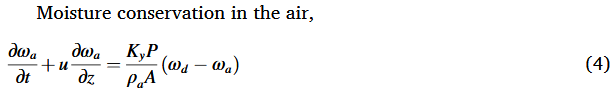

In [ ]:
Nu = 2.45
Sh = 2.45
P_0 = 0.98 * 10^5 # Pa
T_0 = 256 # K
D_a = 2.302 * 10^(-5) * P_0 / P * (T / T_0)^1.81

# thermodynamic properties of moist air
u_reg = 3 # m/s

# geometrical size and properties of desiccant wheel
a = 0.0015 # m, half duct height
b = 0.0015 # m, half duct width
r_0 = 0.2 # m, radius of wheel
L = 0.2 # m, thickness of wheel

P = 2 * pi * r_0
A = 4 * a * b

In [ ]:
using DifferentialEquations
using MethodOfLines

# 定义参数
K_y = ρ_a * Sh * D_a * P / 4 / A # Mass Transfer Coefficient 传输系数（示例值）
## D_a中的T未知
P  # Perimeter 周长
ρ_a = ?  # 空气密度   ## 不知道要不要考虑随温度的变化
A   # 管道横截面积
u = ?   # 风速
h = 1.0     # 换热系数
C_pa = 1.0  # 空气比热容
C_pv = 1.0  # 水蒸气比热容
C_pd = 1.0  # Desiccant 比热容
C_pl = 1.0  # 液体比热容
C_pm = 1.0  # 混合物比热容
f_d = 1.0   # Desiccant 参数
f_m = 1.0   # Desiccant 参数
Q_st = 1.0  # 热量传递


# 空气的初始条件
ω_a_initial(z) = 0.5  # # humidity ratio of desiccant, g/kg
T_a_initial(z) = 290.0  # 空气温度的初始分布
 
# Desiccant 的初始条件
W_initial = 0.5  # 初始 W
ω_d = 0.8   # Desiccant 初始湿度
T_d_initial = 300.0  # 初始 T_d

# 定义 D_a 随 T 变化的函数
function D_a(T)
    return 2.302e-5 * P_0 / P * (T / T_0)^1.81
end

# 定义 K_y 作为温度 T 的函数
function K_y(T)
    return (ρ_a * Sh * D_a(T) * P) / (4 * A)
end

# 定义耦合的湿度和能量方程
function coupled_system!(du, u, p, t, z)
    ω_a, T_a, W, T_d = u  # u 包含四个变量
    
    # 根据当前温度 T_a 计算 K_y
    Ky_air = K_y(T_a)
    Ky_desiccant = K_y(T_d)
    
    # 空气中的湿度守恒方程
    dω_a = -u * gradient(ω_a, z) + (Ky_air * P / (ρ_a * A)) * (ω_d - ω_a)
    
    # 空气中的能量守恒方程
    term1 = (h * P / (ρ_a * A * (C_pa + ω_a * C_pv))) * (T_d - T_a)
    term2 = (Ky_air * C_pv * P / (ρ_a * A * (C_pa + ω_a * C_pv))) * (ω_d - ω_a) * (T_a - T_d)
    dT_a = -u * gradient(T_a, z) + term1 + term2
    
    # Desiccant 中的湿度守恒方程
    dW = (2 * Ky_desiccant * P / f_d) * (ω_a - ω_d)
    
    # Desiccant 中的能量守恒方程
    term3 = (2 * h * P / (f_d * (C_pd + W * C_pl) + f_m * C_pm)) * (T_a - T_d)
    term4 = (2 * Ky_desiccant * P * Q_st / (f_d * (C_pd + W * C_pl) + f_m * C_pm)) * (ω_a - ω_d)
    term5 = (2 * Ky_desiccant * P * C_pv / (f_d * (C_pd + W * C_pl) + f_m * C_pm)) * (ω_a - ω_d) * (T_a - T_d)
    dT_d = term3 + term4 + term5
    
    du[1] .= dω_a  # 空气湿度变化
    du[2] .= dT_a  # 空气温度变化
    du[3] .= dW    # Desiccant 中湿度变化
    du[4] .= dT_d  # Desiccant 中温度变化
end


# 初始条件
function initial_conditions(z)
    return [ω_a_initial(z), T_a_initial(z), W_initial, T_d_initial]
end

# 空间和时间范围
xspan = (0.0, L / 20)
tspan = (0.0, 100.0)

# 使用 Method of Lines 求解耦合方程
dx = 0.1  # 空间步长
pde_prob = MOLFiniteDifference(xspan, dx, initial_conditions, tspan, coupled_system!)

# 求解 PDE 系统
sol = solve(pde_prob)

# 输出解
println("时间点: ", sol.t)
println("解的值: ", sol.u)


In [ ]:
mois_cons_des = @ode_def begin
    dw = -2 * Ky * P * (wa - wd) / fd
    

In [ ]:
要不还是先emprical model吧...
但是TR应该是需要physics based model的吧
或者拟合出TR的empirical model

Moisture conservation in the desiccant
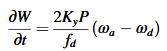

In [ ]:
function moi_conserv_d(du, u, p, t)
    du[1] = 2 * Ky * P * (wa - wd) / fd
end

W0 = ?
tspan = ?

prob = ODEProblem(moi_conserv_d, W0, tspan)